##### NeuralNetwork model

In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import multiprocessing


class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.w_i_h = np.random.uniform(-0.5, 0.5, (hidden_size, input_size))
        self.b_i_h = np.zeros((hidden_size, 1))
        self.w_h_o = np.random.uniform(-0.5, 0.5, (output_size, hidden_size))
        self.b_h_o = np.zeros((output_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, train_images, train_labels, learn_rate=0.01, epochs=3):
        for epoch in range(epochs):
            nr_correct = 0  # Reset nr_correct at the start of each epoch
            start_time = time.time()

            for img, label in zip(train_images, train_labels):
                img = img.reshape(-1, 1)
                label = label.reshape(-1, 1)

                # Forward propagation: input -> hidden
                h_pre = self.w_i_h @ img + self.b_i_h
                h = self.sigmoid(h_pre)

                # Forward propagation: hidden -> output
                o_pre = self.w_h_o @ h + self.b_h_o
                o = self.sigmoid(o_pre)

                # Cost / Error calculation
                nr_correct += int(np.argmax(o) == np.argmax(label))

                # Backpropagation
                delta_o = o - label
                self.w_h_o -= learn_rate * delta_o @ h.T
                self.b_h_o -= learn_rate * delta_o

                delta_h = self.w_h_o.T @ delta_o * (h * (1 - h))
                self.w_i_h -= learn_rate * delta_h @ img.T
                self.b_i_h -= learn_rate * delta_h

            epoch_time = time.time() - start_time
            accuracy = nr_correct / len(train_images) * 100
            print(f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%")
            print(f"Time: {epoch_time:.2f}s")

    def train_mini_batches(
        self, train_images, train_labels, learn_rate=0.01, epochs=3, batch_size=32
    ):
        num_samples = train_images.shape[0]
        for epoch in range(epochs):
            start_time = time.time()
            nr_correct = 0  # Reset nr_correct at the start of each epoch

            # Step 1: Generate indices
            indices = np.arange(num_samples)

            # Step 2: Shuffle indices
            np.random.shuffle(indices)

            # Step 3: Reorder data
            train_images = train_images[indices]
            train_labels = train_labels[indices]

            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_images = train_images[start_idx:end_idx]
                batch_labels = train_labels[start_idx:end_idx]

                batch_size_actual = batch_images.shape[0]  # For the last batch

                # Initialize gradients
                delta_w_i_h = np.zeros_like(self.w_i_h)
                delta_b_i_h = np.zeros_like(self.b_i_h)
                delta_w_h_o = np.zeros_like(self.w_h_o)
                delta_b_h_o = np.zeros_like(self.b_h_o)

                for img, label in zip(batch_images, batch_labels):
                    img = img.reshape(-1, 1)
                    label = label.reshape(-1, 1)

                    # Forward propagation: input -> hidden
                    h_pre = self.w_i_h @ img + self.b_i_h
                    h = self.sigmoid(h_pre)

                    # Forward propagation: hidden -> output
                    o_pre = self.w_h_o @ h + self.b_h_o
                    o = self.sigmoid(o_pre)

                    # Cost / Error calculation
                    nr_correct += int(np.argmax(o) == np.argmax(label))

                    # Backpropagation
                    delta_o = o - label
                    delta_w_h_o += delta_o @ h.T
                    delta_b_h_o += delta_o

                    delta_h = self.w_h_o.T @ delta_o * (h * (1 - h))
                    delta_w_i_h += delta_h @ img.T
                    delta_b_i_h += delta_h

                # Update weights and biases using accumulated gradients
                self.w_i_h -= learn_rate * delta_w_i_h / batch_size_actual
                self.b_i_h -= learn_rate * delta_b_i_h / batch_size_actual
                self.w_h_o -= learn_rate * delta_w_h_o / batch_size_actual
                self.b_h_o -= learn_rate * delta_b_h_o / batch_size_actual

            epoch_time = time.time() - start_time
            accuracy = nr_correct / num_samples * 100
            print(f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%")
            print(f"Time: {epoch_time:.2f}s")

    def train_multi_cores(
        self, train_images, train_labels, learn_rate=0.01, epochs=3, batch_size=32
    ):
        num_samples = train_images.shape[0]
        for epoch in range(epochs):
            nr_correct = 0  # Reset nr_correct at the start of each epoch

            # Shuffle the data at the beginning of each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            train_images = train_images[indices]
            train_labels = train_labels[indices]

            start_time = time.time()

            # Initialize multiprocessing Pool
            num_cores = multiprocessing.cpu_count()
            pool = multiprocessing.Pool(processes=num_cores)

            # Process mini-batches using multiprocessing
            results = []
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_images = train_images[start_idx:end_idx]
                batch_labels = train_labels[start_idx:end_idx]

                # Use multiprocessing to compute gradients in parallel
                result = pool.apply_async(
                    self.compute_gradients, args=(batch_images, batch_labels)
                )
                results.append(result)

            # Close the pool and wait for all processes to finish
            pool.close()
            pool.join()

            # Aggregate results and update weights and biases
            for result in results:
                delta_w_i_h, delta_b_i_h, delta_w_h_o, delta_b_h_o = result.get()
                self.w_i_h -= learn_rate * delta_w_i_h / batch_size
                self.b_i_h -= learn_rate * delta_b_i_h / batch_size
                self.w_h_o -= learn_rate * delta_w_h_o / batch_size
                self.b_h_o -= learn_rate * delta_b_h_o / batch_size

            epoch_time = time.time() - start_time
            accuracy = nr_correct / num_samples * 100
            print(
                f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s"
            )

            # Ensure all processes are terminated
            pool.terminate()
            pool.join()

    def compute_gradients(self, batch_images, batch_labels):
        delta_w_i_h = np.zeros_like(self.w_i_h)
        delta_b_i_h = np.zeros_like(self.b_i_h)
        delta_w_h_o = np.zeros_like(self.w_h_o)
        delta_b_h_o = np.zeros_like(self.b_h_o)

        for img, label in zip(batch_images, batch_labels):
            img = img.reshape(-1, 1)
            label = label.reshape(-1, 1)

            # Forward propagation: input -> hidden
            h_pre = self.w_i_h @ img + self.b_i_h
            h = self.sigmoid(h_pre)

            # Forward propagation: hidden -> output
            o_pre = self.w_h_o @ h + self.b_h_o
            o = self.sigmoid(o_pre)

            # Cost / Error calculation
            nr_correct += int(np.argmax(o) == np.argmax(label))

            # Backpropagation
            delta_o = o - label
            delta_w_h_o += delta_o @ h.T
            delta_b_h_o += delta_o

            delta_h = self.w_h_o.T @ delta_o * (h * (1 - h))
            delta_w_i_h += delta_h @ img.T
            delta_b_i_h += delta_h

        return delta_w_i_h, delta_b_i_h, delta_w_h_o, delta_b_h_o

    def predict(self, img):
        img = img.reshape(-1, 1)

        # Forward propagation: input -> hidden
        h_pre = self.w_i_h @ img + self.b_i_h
        h = self.sigmoid(h_pre)

        # Forward propagation: hidden -> output
        o_pre = self.w_h_o @ h + self.b_h_o
        o = self.sigmoid(o_pre)

        return np.argmax(o), o


def load_mnist_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Normalize the images to [0, 1]
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Flatten the images
    train_images = train_images.reshape((-1, 784))
    test_images = test_images.reshape((-1, 784))

    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels

In [2]:
# Example usage
input_size = 784  # For 28x28 images
hidden_size = 20
output_size = 10  # Number of classes

# Load MNIST data
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network
nn.train(train_images, train_labels, learn_rate=0.01, epochs=3)

# Train the neural network with batch size
nn.train_multi_cores(
    train_images, train_labels, learn_rate=0.01, epochs=3, batch_size=32
)

# Example prediction
example_image = test_images[0]  # Use an image from the test set
true_label = np.argmax(test_labels[0])  # Get the true label for the example image
predicted_label, output_values = nn.predict(example_image)

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

Epoch 1: Accuracy: 86.13%
Time: 1.96s
Epoch 2: Accuracy: 92.22%
Time: 1.98s
Epoch 3: Accuracy: 93.25%
Time: 1.95s


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import time
import multiprocessing


class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.w_i_h = np.random.uniform(-0.5, 0.5, (hidden_size, input_size))
        self.b_i_h = np.zeros((hidden_size, 1))
        self.w_h_o = np.random.uniform(-0.5, 0.5, (output_size, hidden_size))
        self.b_h_o = np.zeros((output_size, 1))

        # Initialize multiprocessing Pool
        self.num_cores = multiprocessing.cpu_count()
        self.pool = multiprocessing.Pool(processes=self.num_cores)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(
        self, train_images, train_labels, learn_rate=0.01, epochs=3, batch_size=32
    ):
        num_samples = train_images.shape[0]
        for epoch in range(epochs):
            nr_correct = 0  # Reset nr_correct at the start of each epoch

            # Shuffle the data at the beginning of each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            train_images = train_images[indices]
            train_labels = train_labels[indices]

            start_time = time.time()

            # Process mini-batches using multiprocessing
            results = []
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_images = train_images[start_idx:end_idx]
                batch_labels = train_labels[start_idx:end_idx]

                # Use multiprocessing to compute gradients in parallel
                result = self.pool.apply_async(
                    self.compute_gradients, args=(batch_images, batch_labels)
                )
                results.append(result)

            # Aggregate results and update weights and biases
            for result in results:
                delta_w_i_h, delta_b_i_h, delta_w_h_o, delta_b_h_o = result.get()
                self.w_i_h -= learn_rate * delta_w_i_h / batch_size
                self.b_i_h -= learn_rate * delta_b_i_h / batch_size
                self.w_h_o -= learn_rate * delta_w_h_o / batch_size
                self.b_h_o -= learn_rate * delta_b_h_o / batch_size

                # Calculate accuracy during training
                nr_correct += np.sum(
                    np.argmax(self.predict(batch_images)[1], axis=1)
                    == np.argmax(batch_labels, axis=1)
                )

            epoch_time = time.time() - start_time
            accuracy = nr_correct / num_samples * 100
            print(
                f"Epoch {epoch + 1}: Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s"
            )

        # Close the multiprocessing pool
        self.pool.close()
        self.pool.join()

    def compute_gradients(self, batch_images, batch_labels):
        delta_w_i_h = np.zeros_like(self.w_i_h)
        delta_b_i_h = np.zeros_like(self.b_i_h)
        delta_w_h_o = np.zeros_like(self.w_h_o)
        delta_b_h_o = np.zeros_like(self.b_h_o)

        for img, label in zip(batch_images, batch_labels):
            img = img.reshape(-1, 1)
            label = label.reshape(-1, 1)

            # Forward propagation: input -> hidden
            h_pre = self.w_i_h @ img + self.b_i_h
            h = self.sigmoid(h_pre)

            # Forward propagation: hidden -> output
            o_pre = self.w_h_o @ h + self.b_h_o
            o = self.sigmoid(o_pre)

            # Backpropagation
            delta_o = o - label
            delta_w_h_o += delta_o @ h.T
            delta_b_h_o += delta_o

            delta_h = self.w_h_o.T @ delta_o * (h * (1 - h))
            delta_w_i_h += delta_h @ img.T
            delta_b_i_h += delta_h

        return delta_w_i_h, delta_b_i_h, delta_w_h_o, delta_b_h_o

    def predict(self, images):
        h_pre = self.w_i_h @ images.T + self.b_i_h
        h = self.sigmoid(h_pre)

        o_pre = self.w_h_o @ h + self.b_h_o
        o = self.sigmoid(o_pre)

        return np.argmax(o, axis=1), o


def load_mnist_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Normalize the images to [0, 1]
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Flatten the images
    train_images = train_images.reshape((-1, 784))
    test_images = test_images.reshape((-1, 784))

    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels


# Example usage
input_size = 784  # For 28x28 images
hidden_size = 20
output_size = 10  # Number of classes

# Load MNIST data
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network
nn.train(train_images, train_labels, learn_rate=0.01, epochs=3, batch_size=32)

# Example prediction
example_image = test_images[0]  # Use an image from the test set
true_label = np.argmax(test_labels[0])  # Get the true label for the example image
predicted_label, output_values = nn.predict(example_image)

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

### 5. So sánh mô hình

#### Common Function

In [18]:
# Hàm vẽ hình và kết quả dự đoán
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{predicted_label} ({true_label})", color=color)


def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

#### Mạng MLP

Epoch 1/5
1875/1875 [==============================] - 2s 808us/step - loss: 0.2381 - accuracy: 0.9302 - val_loss: 0.1160 - val_accuracy: 0.9655
Epoch 2/5
1875/1875 [==============================] - 1s 765us/step - loss: 0.0997 - accuracy: 0.9699 - val_loss: 0.0920 - val_accuracy: 0.9712
Epoch 3/5
1875/1875 [==============================] - 1s 766us/step - loss: 0.0703 - accuracy: 0.9784 - val_loss: 0.0811 - val_accuracy: 0.9737
Epoch 4/5
1875/1875 [==============================] - 1s 764us/step - loss: 0.0534 - accuracy: 0.9829 - val_loss: 0.0707 - val_accuracy: 0.9771
Epoch 5/5
313/313 [==============================] - 0s 432us/step - loss: 0.0750 - accuracy: 0.9775
Test accuracy: 0.9775000214576721
313/313 [==============================] - 0s 374us/step


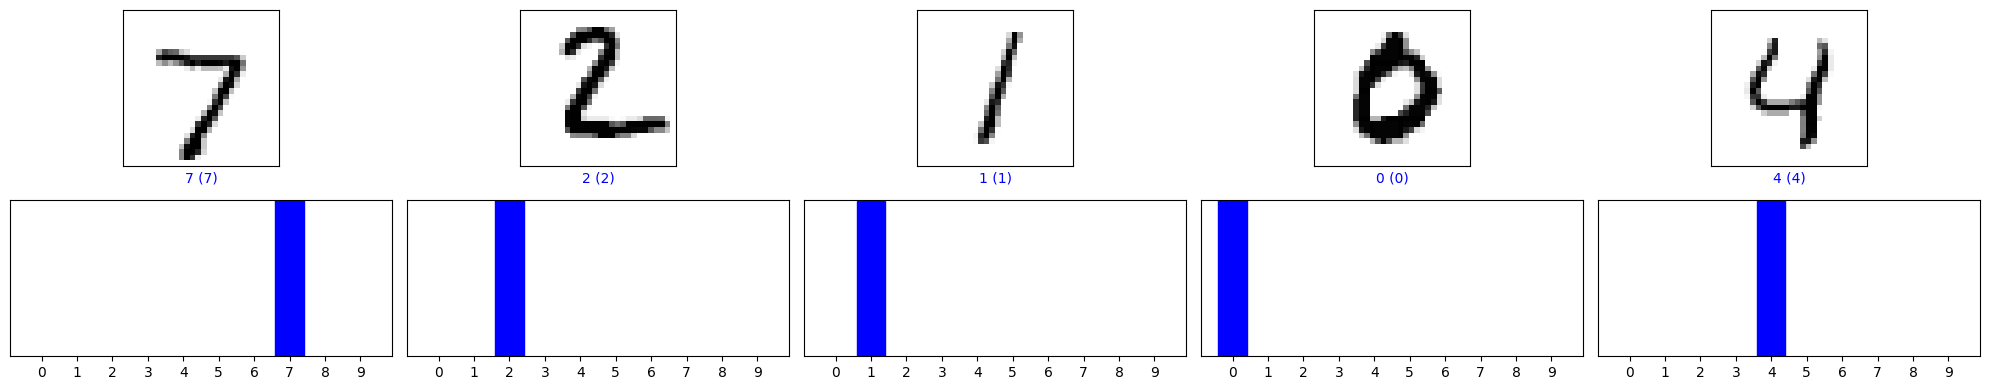

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Xây dựng mô hình MLP
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# Biên dịch mô hình
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

# Kiểm thử một vài hình
predictions = model.predict(x_test)

# Vẽ kết quả của 5 hình đầu tiên
num_images = 5
plt.figure(figsize=(2 * 2 * num_images, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i].reshape(28, 28))
    plt.subplot(2, num_images, i + 1 + num_images)
    plot_value_array(predictions[i], y_test[i])
plt.tight_layout()
plt.show()

#### Mạng CNN

Epoch 1/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1483 - accuracy: 0.9527 - val_loss: 0.0523 - val_accuracy: 0.9838
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0358 - val_accuracy: 0.9880
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0348 - val_accuracy: 0.9894
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0304 - val_accuracy: 0.9906
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0347 - accuracy: 0.9891
Test accuracy: 0.9890999794006348
313/313 [==============================] - 1s 2ms/step


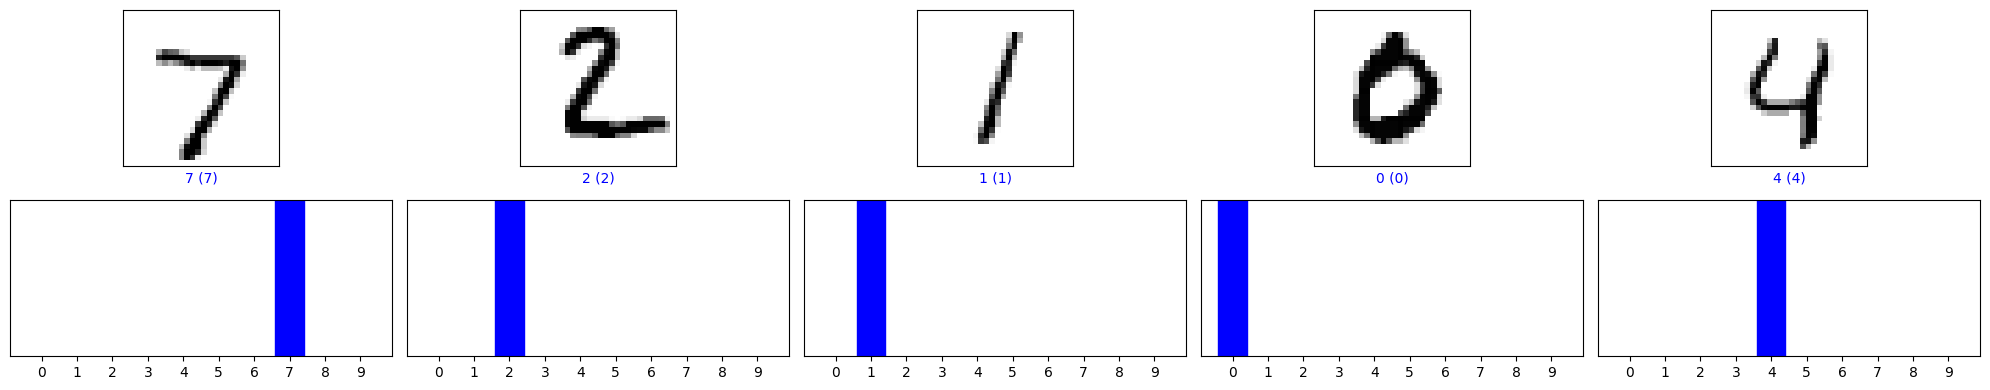

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape dữ liệu cho CNN
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Xây dựng mô hình CNN
model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# Biên dịch mô hình
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

# Kiểm thử một vài hình
predictions = model.predict(x_test)

# Vẽ kết quả của 5 hình đầu tiên
num_images = 5
plt.figure(figsize=(2 * 2 * num_images, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i].reshape(28, 28))
    plt.subplot(2, num_images, i + 1 + num_images)
    plot_value_array(predictions[i], y_test[i])
plt.tight_layout()
plt.show()

### Practice

Version 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = (
    train_images.reshape(train_images.shape[0], -1) / 255.0
)  # Flatten and normalize
test_images = (
    test_images.reshape(test_images.shape[0], -1) / 255.0
)  # Flatten and normalize
train_labels = np.eye(10)[train_labels]  # One-hot encode labels
test_labels = np.eye(10)[test_labels]  # One-hot encode labels

# Initialize weights and biases
w_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
b_i_h = np.zeros((20, 1))
w_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
b_h_o = np.zeros((10, 1))

# Training parameters
learn_rate = 0.01
epochs = 3

# Training loop
for epoch in range(epochs):
    nr_correct = 0  # Reset nr_correct at the start of each epoch
    for img, l in zip(train_images, train_labels):
        img = img.reshape(784, 1)  # Ensure img is a column vector
        l = l.reshape(10, 1)  # Ensure label is a column vector

        # Forward propagation: input -> hidden
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))

        # Forward propagation: hidden -> output
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        # Cost / Error calculation
        nr_correct += int(np.argmax(o) == np.argmax(l))

        # Backpropagation
        delta_o = o - l
        w_h_o -= learn_rate * delta_o @ h.T
        b_h_o -= learn_rate * delta_o
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))
        w_i_h -= learn_rate * delta_h @ img.T
        b_i_h -= learn_rate * delta_h

    print(
        f"Epoch {epoch + 1}/{epochs}, Total Images: {len(train_images)}, Correct Predictions: {nr_correct}"
    )
    print(f"Accuracy: {nr_correct / len(train_images) * 100:.2f}%")

# Testing the model
nr_correct_test = 0
for img, l in zip(test_images, test_labels):
    img = img.reshape(784, 1)
    l = l.reshape(10, 1)

    # Forward propagation: input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))

    # Forward propagation: hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))

    # Count correct predictions
    nr_correct_test += int(np.argmax(o) == np.argmax(l))

print(
    f"Test set: Total Images: {len(test_images)}, Correct Predictions: {nr_correct_test}"
)
print(f"Test Accuracy: {nr_correct_test / len(test_images) * 100:.2f}%")

Epoch 1/3, Total Images: 60000, Correct Predictions: 51778
Accuracy: 86.30%
Epoch 2/3, Total Images: 60000, Correct Predictions: 55351
Accuracy: 92.25%
Epoch 3/3, Total Images: 60000, Correct Predictions: 56077
Accuracy: 93.46%
Test set: Total Images: 10000, Correct Predictions: 9340
Test Accuracy: 93.40%


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = (
    train_images.reshape(train_images.shape[0], -1) / 255.0
)  # Flatten and normalize
test_images = (
    test_images.reshape(test_images.shape[0], -1) / 255.0
)  # Flatten and normalize
train_labels = np.eye(10)[train_labels]  # One-hot encode labels
test_labels = np.eye(10)[test_labels]  # One-hot encode labels

# Initialize weights and biases
w_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
b_i_h = np.zeros((20, 1))
w_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
b_h_o = np.zeros((10, 1))

# Training parameters
learn_rate = 0.01
epochs = 3

# Training loop
for epoch in range(epochs):
    nr_correct = 0  # Reset nr_correct at the start of each epoch
    for img, l in zip(train_images, train_labels):
        img = img.reshape(784, 1)  # Ensure img is a column vector
        l = l.reshape(10, 1)  # Ensure label is a column vector

        # Forward propagation: input -> hidden
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))

        # Forward propagation: hidden -> output
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        # Cost / Error calculation
        nr_correct += int(np.argmax(o) == np.argmax(l))

        # Backpropagation
        delta_o = o - l
        w_h_o -= learn_rate * delta_o @ h.T
        b_h_o -= learn_rate * delta_o
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))
        w_i_h -= learn_rate * delta_h @ img.T
        b_i_h -= learn_rate * delta_h

    print(
        f"Epoch {epoch + 1}/{epochs}, Total Images: {len(train_images)}, Correct Predictions: {nr_correct}"
    )
    print(f"Accuracy: {nr_correct / len(train_images) * 100:.2f}%")

# Save model to files
np.save("w_i_h.npy", w_i_h)
np.save("b_i_h.npy", b_i_h)
np.save("w_h_o.npy", w_h_o)
np.save("b_h_o.npy", b_h_o)


# Function to load model from files
def load_model():
    w_i_h = np.load("w_i_h.npy")
    b_i_h = np.load("b_i_h.npy")
    w_h_o = np.load("w_h_o.npy")
    b_h_o = np.load("b_h_o.npy")
    return w_i_h, b_i_h, w_h_o, b_h_o


# Load model
w_i_h, b_i_h, w_h_o, b_h_o = load_model()

# Testing the model
nr_correct_test = 0
for img, l in zip(test_images, test_labels):
    img = img.reshape(784, 1)
    l = l.reshape(10, 1)

    # Forward propagation: input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))

    # Forward propagation: hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))

    # Count correct predictions
    nr_correct_test += int(np.argmax(o) == np.argmax(l))

print(
    f"Test set: Total Images: {len(test_images)}, Correct Predictions: {nr_correct_test}"
)
print(f"Test Accuracy: {nr_correct_test / len(test_images) * 100:.2f}%")

Epoch 1/3, Total Images: 60000, Correct Predictions: 51514
Accuracy: 85.86%
Epoch 2/3, Total Images: 60000, Correct Predictions: 55429
Accuracy: 92.38%
Epoch 3/3, Total Images: 60000, Correct Predictions: 56006
Accuracy: 93.34%
Test set: Total Images: 10000, Correct Predictions: 9344
Test Accuracy: 93.44%


Version 3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = (
    train_images.reshape(train_images.shape[0], -1) / 255.0
)  # Flatten and normalize
test_images = (
    test_images.reshape(test_images.shape[0], -1) / 255.0
)  # Flatten and normalize
train_labels = np.eye(10)[train_labels]  # One-hot encode labels
test_labels = np.eye(10)[test_labels]  # One-hot encode labels

# Initialize weights and biases
w_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
b_i_h = np.zeros((20, 1))
w_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
b_h_o = np.zeros((10, 1))

# Training parameters
learn_rate = 0.01
epochs = 3

# Training loop
for epoch in range(epochs):
    nr_correct = 0  # Reset nr_correct at the start of each epoch
    for img, l in zip(train_images, train_labels):
        img = img.reshape(784, 1)  # Ensure img is a column vector
        l = l.reshape(10, 1)  # Ensure label is a column vector

        # Forward propagation: input -> hidden
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))

        # Forward propagation: hidden -> output
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        # Cost / Error calculation
        nr_correct += int(np.argmax(o) == np.argmax(l))

        # Backpropagation
        delta_o = o - l
        w_h_o -= learn_rate * delta_o @ h.T
        b_h_o -= learn_rate * delta_o
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))
        w_i_h -= learn_rate * delta_h @ img.T
        b_i_h -= learn_rate * delta_h

    print(
        f"Epoch {epoch + 1}/{epochs}, Total Images: {len(train_images)}, Correct Predictions: {nr_correct}"
    )
    print(f"Accuracy: {nr_correct / len(train_images) * 100:.2f}%")

# Save model to files
np.save("w_i_h.npy", w_i_h)
np.save("b_i_h.npy", b_i_h)
np.save("w_h_o.npy", w_h_o)
np.save("b_h_o.npy", b_h_o)


# Function to load model from files
def load_model():
    w_i_h = np.load("w_i_h.npy")
    b_i_h = np.load("b_i_h.npy")
    w_h_o = np.load("w_h_o.npy")
    b_h_o = np.load("b_h_o.npy")
    return w_i_h, b_i_h, w_h_o, b_h_o


# Load model
w_i_h, b_i_h, w_h_o, b_h_o = load_model()

# Testing the model
nr_correct_test = 0
for img, l in zip(test_images, test_labels):
    img = img.reshape(784, 1)
    l = l.reshape(10, 1)

    # Forward propagation: input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))

    # Forward propagation: hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))

    # Count correct predictions
    nr_correct_test += int(np.argmax(o) == np.argmax(l))

print(
    f"Test set: Total Images: {len(test_images)}, Correct Predictions: {nr_correct_test}"
)
print(f"Test Accuracy: {nr_correct_test / len(test_images) * 100:.2f}%")

Epoch 1/3, Total Images: 60000, Correct Predictions: 51525
Accuracy: 85.88%
Epoch 2/3, Total Images: 60000, Correct Predictions: 55286
Accuracy: 92.14%
Epoch 3/3, Total Images: 60000, Correct Predictions: 55914
Accuracy: 93.19%
Test set: Total Images: 10000, Correct Predictions: 9278
Test Accuracy: 92.78%


Version 3

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = (
    train_images.reshape(train_images.shape[0], -1) / 255.0
)  # Flatten and normalize
test_images = (
    test_images.reshape(test_images.shape[0], -1) / 255.0
)  # Flatten and normalize
train_labels = np.eye(10)[train_labels]  # One-hot encode labels
test_labels = np.eye(10)[test_labels]  # One-hot encode labels

# Initialize weights and biases
w_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
b_i_h = np.zeros((20, 1))
w_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
b_h_o = np.zeros((10, 1))

# Training parameters
learn_rate = 0.01
epochs = 3

# Training loop
for epoch in range(epochs):
    nr_correct = 0  # Reset nr_correct at the start of each epoch
    for img, l in zip(train_images, train_labels):
        img = img.reshape(784, 1)  # Ensure img is a column vector
        l = l.reshape(10, 1)  # Ensure label is a column vector

        # Forward propagation: input -> hidden
        h_pre = b_i_h + w_i_h @ img
        h = 1 / (1 + np.exp(-h_pre))

        # Forward propagation: hidden -> output
        o_pre = b_h_o + w_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        # Cost / Error calculation
        nr_correct += int(np.argmax(o) == np.argmax(l))

        # Backpropagation
        delta_o = o - l
        w_h_o -= learn_rate * delta_o @ h.T
        b_h_o -= learn_rate * delta_o
        delta_h = w_h_o.T @ delta_o * (h * (1 - h))
        w_i_h -= learn_rate * delta_h @ img.T
        b_i_h -= learn_rate * delta_h

    print(
        f"Epoch {epoch + 1}/{epochs}, Total Images: {len(train_images)}, Correct Predictions: {nr_correct}"
    )
    print(f"Accuracy: {nr_correct / len(train_images) * 100:.2f}%")

# Save model to a single file
np.savez("model.npz", w_i_h=w_i_h, b_i_h=b_i_h, w_h_o=w_h_o, b_h_o=b_h_o)


# Function to load model from a single file
def load_model(filename):
    data = np.load(filename)
    w_i_h = data["w_i_h"]
    b_i_h = data["b_i_h"]
    w_h_o = data["w_h_o"]
    b_h_o = data["b_h_o"]
    return w_i_h, b_i_h, w_h_o, b_h_o


# Load model
w_i_h, b_i_h, w_h_o, b_h_o = load_model("model.npz")

# Testing the model
nr_correct_test = 0
for img, l in zip(test_images, test_labels):
    img = img.reshape(784, 1)
    l = l.reshape(10, 1)

    # Forward propagation: input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))

    # Forward propagation: hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))

    # Count correct predictions
    nr_correct_test += int(np.argmax(o) == np.argmax(l))

print(
    f"Test set: Total Images: {len(test_images)}, Correct Predictions: {nr_correct_test}"
)
print(f"Test Accuracy: {nr_correct_test / len(test_images) * 100:.2f}%")

Epoch 1/3, Total Images: 60000, Correct Predictions: 51427
Accuracy: 85.71%
Epoch 2/3, Total Images: 60000, Correct Predictions: 55272
Accuracy: 92.12%
Epoch 3/3, Total Images: 60000, Correct Predictions: 55961
Accuracy: 93.27%
Test set: Total Images: 10000, Correct Predictions: 9287
Test Accuracy: 92.87%


Draw and predict

In [8]:
import numpy as np
import tkinter as tk
from PIL import Image, ImageDraw

# Skip


# Load model from a single file
def load_model(filename):
    data = np.load(filename)
    w_i_h = data["w_i_h"]
    b_i_h = data["b_i_h"]
    w_h_o = data["w_h_o"]
    b_h_o = data["b_h_o"]
    return w_i_h, b_i_h, w_h_o, b_h_o


w_i_h, b_i_h, w_h_o, b_h_o = load_model("model.npz")


# Define forward propagation function
def predict(img):
    img = img.reshape(784, 1)
    h_pre = b_i_h + w_i_h @ img
    h = 1 / (1 + np.exp(-h_pre))
    o_pre = b_h_o + w_h_o @ h
    o = 1 / (1 + np.exp(-o_pre))
    return np.argmax(o)


# GUI for drawing
class DrawingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Handwritten Digit Recognition")
        self.canvas = tk.Canvas(self.root, width=200, height=200, bg="white")
        self.canvas.pack()
        self.canvas.bind("<B1-Motion>", self.paint)
        self.button = tk.Button(self.root, text="Predict", command=self.predict_digit)
        self.button.pack()
        self.image = Image.new("L", (200, 200), 255)
        self.draw = ImageDraw.Draw(self.image)

    def paint(self, event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", width=5)
        self.draw.line([x1, y1, x2, y2], fill="black", width=5)

    def predict_digit(self):
        self.image = self.image.resize((28, 28))
        img_array = np.array(self.image)
        img_array = (
            255 - img_array
        )  # Invert colors: white (255) to black (0) and black (0) to white (255)
        img_array = img_array / 255.0  # Normalize
        prediction = predict(img_array)
        self.show_result(prediction)

    def show_result(self, prediction):
        result_window = tk.Toplevel(self.root)
        result_window.title("Prediction Result")
        result_label = tk.Label(
            result_window, text=f"Predicted Digit: {prediction}", font=("Helvetica", 24)
        )
        result_label.pack()


if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()

Practice for one image

In [9]:
x_test.shape

(10000, 28, 28, 1)

In [10]:
one_image = np.expand_dims(x_test[0], 0)
one_image.shape

(1, 28, 28, 1)

In [11]:
prediction = model.predict(one_image)
prediction

1/1 [==============================] - 0s 0s/step


array([[7.3650697e-11, 6.0867188e-07, 7.7270752e-06, 5.4430306e-08,
        6.9366521e-08, 4.0069224e-08, 6.5427264e-14, 9.9998319e-01,
        7.5989897e-06, 8.2894468e-07]], dtype=float32)

In [12]:
predicted_probabilities = prediction[0]
predicted_probabilities

array([7.3650697e-11, 6.0867188e-07, 7.7270752e-06, 5.4430306e-08,
       6.9366521e-08, 4.0069224e-08, 6.5427264e-14, 9.9998319e-01,
       7.5989897e-06, 8.2894468e-07], dtype=float32)

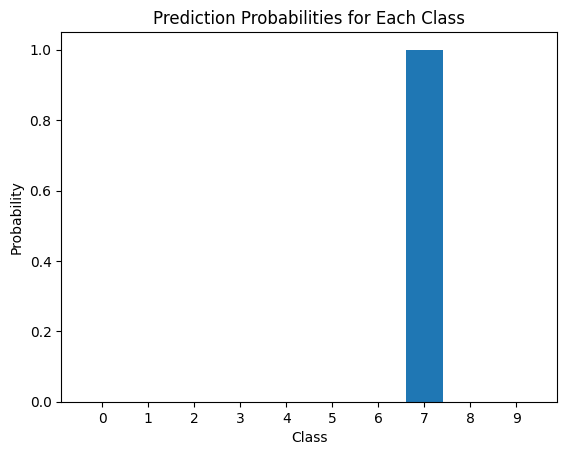

In [13]:
# Labels for the x-axis (digits 0-9 for MNIST)
labels = np.arange(10)

# Plot the bar chart
plt.bar(labels, predicted_probabilities)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Prediction Probabilities for Each Class")
plt.xticks(labels)  # Set the x-axis labels to be the class labels (0-9)
plt.show()

In [14]:
model.save("model.h5")

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1487 - accuracy: 0.9547 - val_loss: 0.0656 - val_accuracy: 0.9791
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0469 - accuracy: 0.9855 - val_loss: 0.0382 - val_accuracy: 0.9869
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0269 - accuracy: 0.9917
Test accuracy: 0.9916999936103821
313/313 [==============================] - 1s 2ms/step


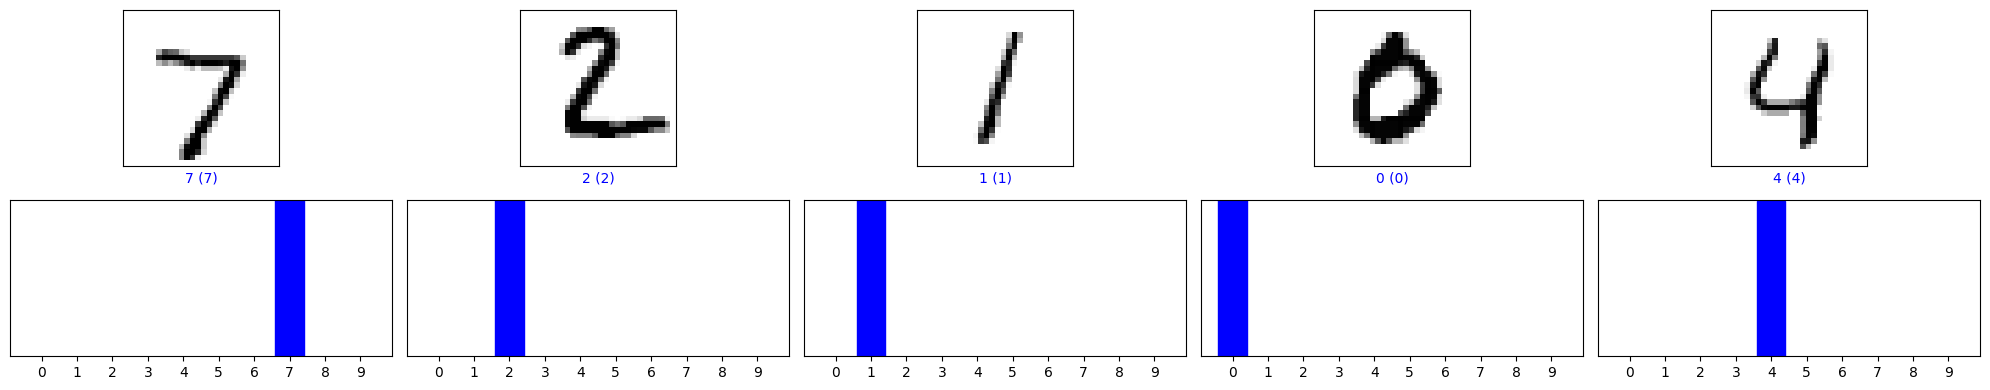

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape dữ liệu cho CNN
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Xây dựng mô hình CNN
model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# Biên dịch mô hình
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

# Kiểm thử một vài hình
predictions = model.predict(x_test)


# Hàm vẽ hình và kết quả dự đoán
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{predicted_label} ({true_label})", color=color)


def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")


# Vẽ kết quả của 5 hình đầu tiên
num_images = 5
plt.figure(figsize=(2 * 2 * num_images, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i].reshape(28, 28))
    plt.subplot(2, num_images, i + 1 + num_images)
    plot_value_array(predictions[i], y_test[i])
plt.tight_layout()
plt.show()

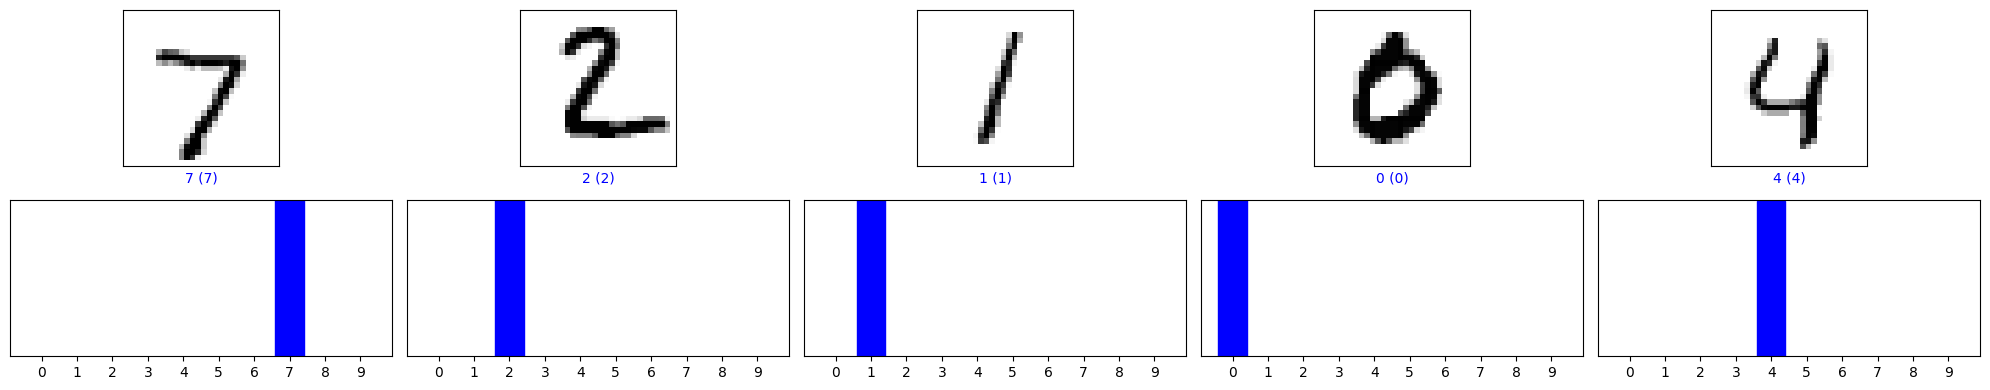

In [16]:
# Hàm vẽ hình và kết quả dự đoán
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{predicted_label} ({true_label})", color=color)


def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")


# Vẽ kết quả của 5 hình đầu tiên
num_images = 5
plt.figure(figsize=(2 * 2 * num_images, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i].reshape(28, 28))
    plt.subplot(2, num_images, i + 1 + num_images)
    plot_value_array(predictions[i], y_test[i])
plt.tight_layout()
plt.show()

Epoch 1/5
1875/1875 [==============================] - 2s 952us/step - loss: 0.2401 - accuracy: 0.9286 - val_loss: 0.1151 - val_accuracy: 0.9630
Epoch 2/5
1875/1875 [==============================] - 2s 808us/step - loss: 0.1009 - accuracy: 0.9684 - val_loss: 0.1041 - val_accuracy: 0.9681
Epoch 3/5
1875/1875 [==============================] - 2s 810us/step - loss: 0.0710 - accuracy: 0.9781 - val_loss: 0.0919 - val_accuracy: 0.9723
Epoch 4/5
1875/1875 [==============================] - 2s 827us/step - loss: 0.0562 - accuracy: 0.9827 - val_loss: 0.1095 - val_accuracy: 0.9680
Epoch 5/5
313/313 [==============================] - 0s 476us/step - loss: 0.0910 - accuracy: 0.9752
Test accuracy: 0.9751999974250793
313/313 [==============================] - 0s 374us/step


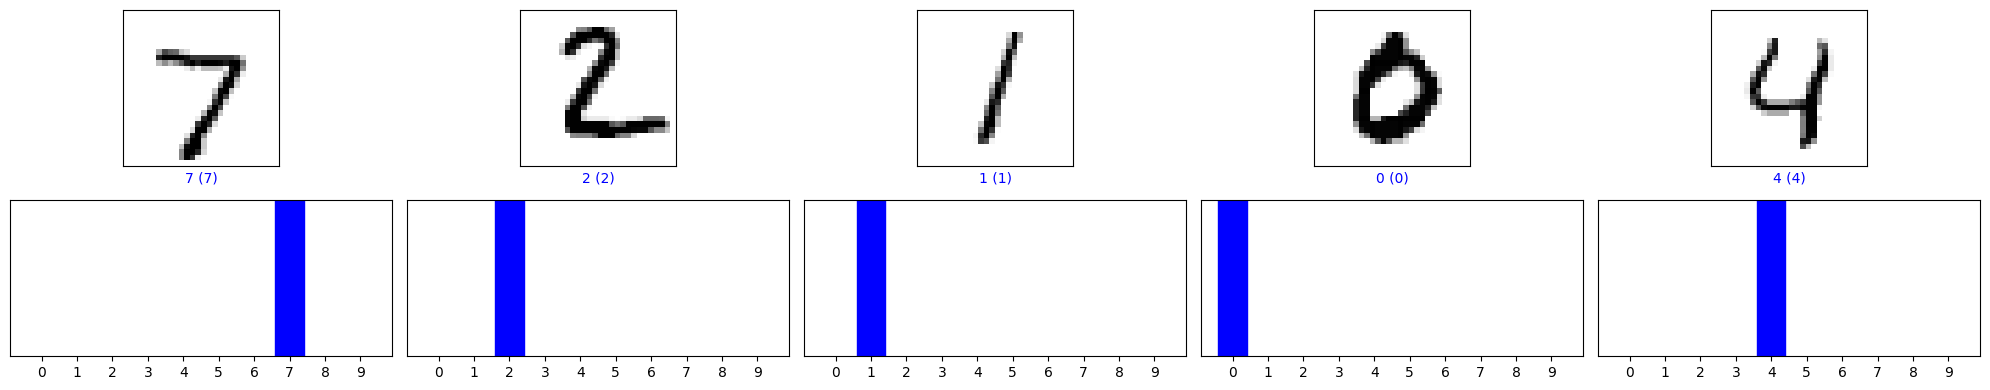

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Xây dựng mô hình MLP
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# Biên dịch mô hình
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

# Kiểm thử một vài hình
predictions = model.predict(x_test)


# Hàm vẽ hình và kết quả dự đoán
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{predicted_label} ({true_label})", color=color)


def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")


# Vẽ kết quả của 5 hình đầu tiên
num_images = 5
plt.figure(figsize=(2 * 2 * num_images, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i].reshape(28, 28))
    plt.subplot(2, num_images, i + 1 + num_images)
    plot_value_array(predictions[i], y_test[i])
plt.tight_layout()
plt.show()